In [1]:
import sys
sys.path.append('/cluster/sj1')

In [53]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from collections import namedtuple
import torch.distributions as tdist
import bb_opt.src.reparam_trainer as reparam
import numpy as np
from scipy.stats import kendalltau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from gpu_utils.utils import gpu_init
from tqdm import tnrange

gpu_id = gpu_init()
print(f"Running on GPU {gpu_id}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running on GPU 0


In [58]:
Params = namedtuple('params', ['lr', 'num_latents', 'output_dist_fn', 'prior_mean', 'prior_std', 'num_epochs', 'num_samples', 'batch_size', 'device', 'exp_noise_samples'])
params = Params(batch_size=100, num_latents=20, output_dist_fn=tdist.Normal, num_samples=10, exp_noise_samples=2, lr=1e-3, prior_mean=0., prior_std=1., device='cuda', num_epochs=1000)

In [27]:
def jointplot(predicted, true, title: str=""):
    if isinstance(predicted, torch.Tensor):
        predicted = predicted.detach().cpu().numpy()

    if isinstance(true, torch.Tensor):
        true = true.detach().cpu().numpy()
        
    ax = sns.jointplot(predicted, true, s=3, alpha=0.5)
    #ax = sns.regplot(predicted, true)
    ax.set_axis_labels('Predicted', 'True')
    ax.ax_marg_x.set_title(title)
    return ax

In [6]:
n_train = 1000

project = "dna_binding"
dataset = "crx_ref_r1"
batch_size = 1
retrain_every = 1000000
partial_steps = 20

root = "/cluster/sj1/bb_opt/"
data_dir = root+"data/"+project+"/"+dataset+"/"
inputs = np.load(data_dir+"inputs.npy")
labels = np.load(data_dir+"labels.npy")
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, train_size=n_train, random_state=521)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs, train_labels, train_size=0.9, random_state=521)

top_k_percent = 1

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
train_label_mean = train_labels.mean()
train_label_std = train_labels.std()

train_labels = (train_labels - train_label_mean) / train_label_std
val_labels = (val_labels - train_label_mean) / train_label_std
test_labels = (test_labels - train_label_mean) / train_label_std

In [11]:
def get_mean_preds(num_samples, muYhat, stdYhat):
    Yhat = []
    for i in range(num_samples):
        for j in range(muYhat.shape[1]):
            Yhat += [torch.normal(muYhat[:, j], stdYhat[:, j])]
    Yhat = torch.stack(Yhat, dim=0).t().mean(1).cpu().numpy()
    return Yhat

In [87]:
N_HIDDEN = 100
NON_LINEARITY = "ReLU"

class Qz(nn.Module):
    def __init__(self, num_latent):
        super(Qz, self).__init__()
        self.mu_z = Parameter(torch.zeros(num_latent))
        self.std_z = Parameter(torch.ones(num_latent))
        
    def forward(self, e):
        return self.mu_z.unsqueeze(0) + e*self.std_z.unsqueeze(0)
        
def get_model_nn(n_inputs: int = 512, num_latent: int = 20):
    global device
    device = device or "cpu"

    model = nn.Sequential(
        nn.Linear(n_inputs + num_latent, N_HIDDEN),
        getattr(nn, NON_LINEARITY)(),
        nn.Linear(N_HIDDEN, 2),
    ).to(device)

    def init_weights(module):
        if isinstance(module, nn.Linear):
            torch.nn.init.kaiming_normal_(
                module.weight.data, mode="fan_out", nonlinearity="relu"
            )

    model.apply(init_weights)
    model.train()
    
    qz = Qz(num_latent).to('cuda')
    qz.train()
    
    mu_e = torch.zeros(num_latent, requires_grad=False).to(device)
    std_e = torch.ones(num_latent, requires_grad=False).to(device)
    
    e_dist = tdist.Normal(mu_e + params.prior_mean, std_e*params.prior_std)
    
    return model, qz, e_dist

In [99]:
import bb_opt.src.reparam_trainer as reparam

In [113]:
params = Params(batch_size=10, num_latents=20, output_dist_fn=tdist.Normal, num_samples=50, exp_noise_samples=3, lr=1e-3, prior_mean=0., prior_std=1., device='cuda', num_epochs=1000)

In [114]:
model, qz, e_dist = get_model_nn(inputs.shape[1], params.num_latents)

train_losses = []
train_kl_losses = []
val_losses = []

train_corrs = []
val_corrs = []

N = train_inputs.shape[0]
num_batches = N//params.batch_size
model_parameters = []
for m in [model, qz]:
    model_parameters += list(m.parameters())
batches, optim = reparam.init_train(params, model_parameters, train_inputs, train_labels)

In [ ]:
model_path = "crx_100_starter_sid"

#progress = tnrange(params.num_epochs)
progress = tnrange(1000)

train_X = torch.FloatTensor(train_inputs)
train_Y = torch.FloatTensor(train_labels)
val_X = torch.FloatTensor(val_inputs)
val_Y = torch.FloatTensor(val_labels)


for epoch_iter in progress:
    for bi in range(num_batches):
        bs = batches[bi]
        be = batches[bi+1]
        bN = be-bs

        bX = train_X[bs:be]
        bY = train_Y[bs:be]

        e = []
        for si in range(params.num_samples):
            e += [e_dist.sample()]
        e = torch.stack(e, dim=0).to(device)

        loss, log_prob_loss, kl_loss, _, _ = reparam.compute_loss(params, bX, bY, optim, model, qz, e)
        train_losses += [log_prob_loss]
        train_kl_losses += [kl_loss]
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        
    e = []
    for si in range(params.num_samples):
        e += [e_dist.sample()]
    e = torch.stack(e, dim=0)
    _, _, _, muYhat, stdYhat = reparam.compute_loss(params, train_X, train_Y, optim, model, qz, e)
    
    muYhat = muYhat.detach()
    stdYhat = stdYhat.detach()
    
    muYhat.shape[0] == train_inputs.shape[0]
    assert muYhat.shape[1] == params.num_samples
    
    preds = get_mean_preds(params.exp_noise_samples, muYhat, stdYhat)
    assert preds.shape == train_labels.shape
        
    train_corrs.append(kendalltau(preds, train_labels)[0])

#     if n_inputs == 1:
#         mses.append((preds - train_labels.item()) ** 2)

    _, _, _, muYhat, stdYhat = reparam.compute_loss(params, val_X, val_Y, optim, model, qz, e)
    
    muYhat = muYhat.detach()
    stdYhat = stdYhat.detach()
    
    muYhat.shape[0] == val_inputs.shape[0]
    assert muYhat.shape[1] == params.num_samples
    
    preds = get_mean_preds(params.exp_noise_samples, muYhat, stdYhat)
    assert preds.shape == val_labels.shape
    
    val_corr = kendalltau(preds, val_labels)[0]

    val_corrs.append(val_corr)
    progress.set_description(f"Corr: {val_corr:.3f}")

A Jupyter Widget

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


train_corrcoef: -0.016964735273621183
val_corrcoef: -0.035748726921066246


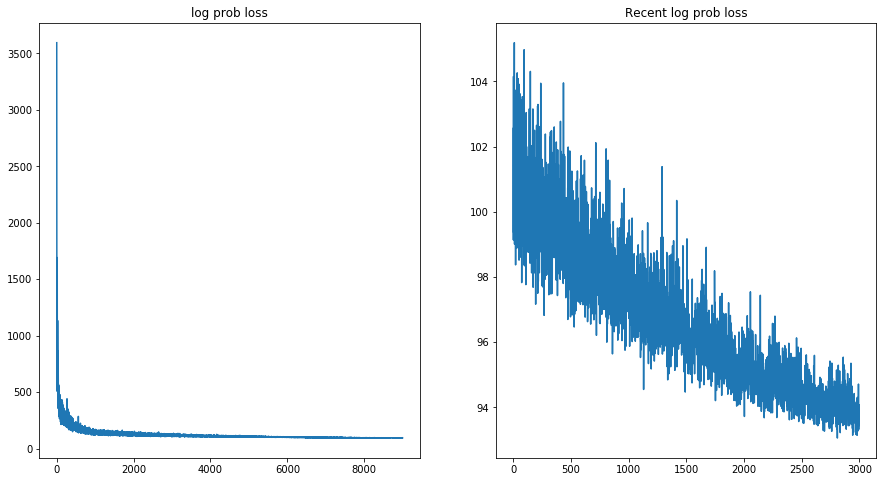

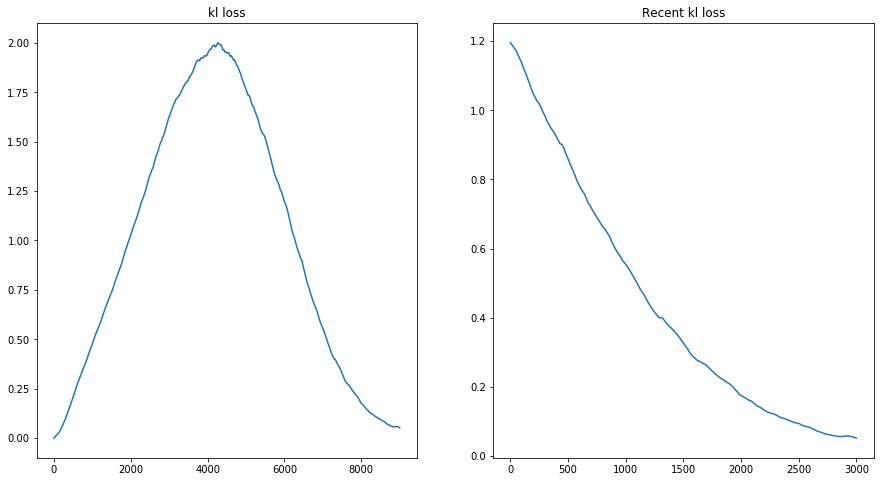

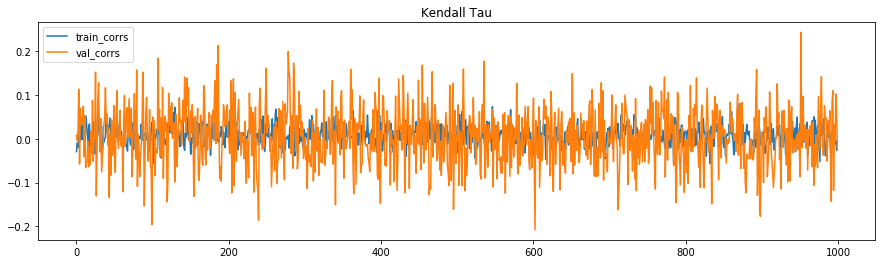

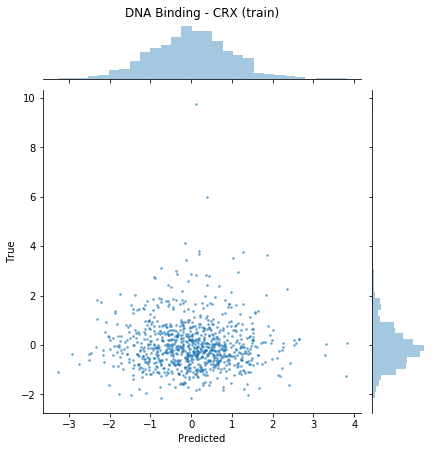

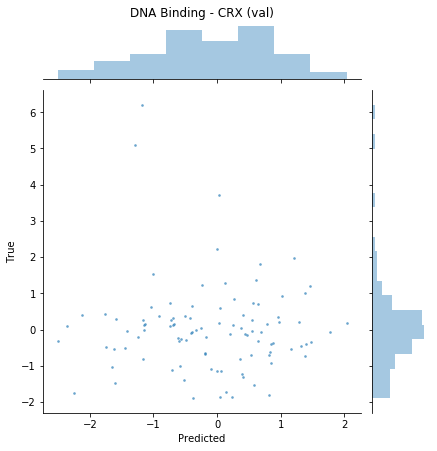

In [110]:
plt.figure(figsize=(15, 8))

plt.subplot(121)
plt.plot(train_losses)
plt.title("log prob loss")

plt.subplot(122)
plt.plot(train_losses[-3000:])
plt.title("Recent log prob loss")

plt.figure(figsize=(15, 8))

plt.subplot(121)
plt.plot(train_kl_losses)
plt.title("kl loss")

plt.subplot(122)
plt.plot(train_kl_losses[-3000:])
plt.title("Recent kl loss")

plt.figure(figsize=(15, 4))

# plt.subplot(121)
# plt.plot(mses)
# plt.title("MSE")

# plt.subplot(122)
plt.plot(train_corrs, label="train_corrs")
plt.plot(val_corrs, label="val_corrs")
plt.legend()
plt.title("Kendall Tau");
# plt.plot(pd.Series(losses[-3000:]).rolling(window=100).median());

title = "DNA Binding - CRX"
train_title = title + " (train)"
val_title = title + " (val)"

if n_train > 1:
    _, _, _, muYhat, stdYhat = reparam.compute_loss(params, train_X, train_Y, optim, model, qz, e)
    muYhat = muYhat.detach()
    stdYhat = stdYhat.detach()
    preds = get_mean_preds(params.exp_noise_samples, muYhat, stdYhat)
    jointplot(preds, train_labels, train_title)
    print('train_corrcoef:', np.corrcoef(preds, train_labels)[0, 1])

_, _, _, muYhat, stdYhat = reparam.compute_loss(params, val_X, val_Y, optim, model, qz, e)
muYhat = muYhat.detach()
stdYhat = stdYhat.detach()
preds = get_mean_preds(params.exp_noise_samples, muYhat, stdYhat)
jointplot(preds, val_labels, val_title)
print('val_corrcoef:', np.corrcoef(preds, val_labels)[0, 1])